In [38]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from IPS import IPS
from AdaIPS_v2 import AdaIPS_S
from getData import getData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        
        self.t_losses = []
        self.v_losses = []
        

    def forward(self, x):
        x = x.view(-1, 28*28).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [40]:
epochs = 10
batch_size = 64


In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainloader, trainset, testloader, testset, validationloader, valset = getData('FashionMNIST', transform=transform, batch_size=batch_size)

In [42]:
def train(model, optimizer, epochs=2):
    model.train()
    print(optimizer)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    num_epochs = epochs
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

    
            # if i % 100 == 0:                
            #     with torch.no_grad():
            #         for v_i, (v_inputs, v_labels) in enumerate(validationloader):
            #             v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)
            #             v_outputs = model(v_inputs)
            #             v_loss = criterion(v_outputs, v_labels)
                    
            #         print("validation loss", v_loss.item())                   
            #     model.v_losses.append(v_loss.item())
                
            loss = optimizer.step(closure)
            running_loss += loss
            
            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Step {i}, Loss: {loss}')
                model.t_losses.append(loss.item())
        
        # model.t_losses.append(running_loss / len(trainloader.dataset))
            

    print("Training complete.")
    return model

In [43]:
def test(model):
    model.eval()
    for i, (inputs, labels) in enumerate(testloader):
        with torch.no_grad():
            output = model(inputs)
            output = output.argmax(axis=1)
        
        print(np.unique(output.detach().numpy()))
        precision, recall, fscore, _ = precision_recall_fscore_support(labels, output.detach().numpy(), average='weighted')
        print(accuracy_score(labels, output.detach().numpy()))
        print(precision, recall, fscore)
        

        precision, recall, fscore, support = precision_recall_fscore_support(labels, output, average=None)

        for i in range(10):
            print(f"Class {i} -> Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-score: {fscore[i]:.4f}")


In [44]:
adaIpsModel = SimpleNN().to(device)
adaIpsOptimizer = AdaIPS_S(adaIpsModel.parameters(), T=epochs * (len(trainset)/batch_size), lower_bound=0, beta_1=0.9, beta_2=0.99)
train(adaIpsModel, adaIpsOptimizer, epochs=epochs)

initialized optimizer with per layer learning rate: False
AdaIPS_S (
Parameter Group 0
    T0: 7500.0
    beta_1: 0.9
    beta_2: 0.99
    eps: 1e-08
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.294565200805664
Epoch 1, Step 100, Loss: 0.7896333336830139
Epoch 1, Step 200, Loss: 0.33282071352005005
Epoch 1, Step 300, Loss: 0.3638940453529358
Epoch 1, Step 400, Loss: 0.19455169141292572
Epoch 1, Step 500, Loss: 0.20947648584842682
Epoch 1, Step 600, Loss: 0.07472345978021622
Epoch 1, Step 700, Loss: 0.12879373133182526
Epoch 2, Step 0, Loss: 0.08627045154571533
Epoch 2, Step 100, Loss: 0.158939927816391
Epoch 2, Step 200, Loss: 0.10577408969402313
Epoch 2, Step 300, Loss: 0.14825308322906494
Epoch 2, Step 400, Loss: 0.20543627440929413
Epoch 2, Step 500, Loss: 0.17367227375507355
Epoch 2, Step 600, Loss: 0.0214596688747406
Epoch 2, Step 700, Loss: 0.06034517288208008
Epoch 3, Step 0, Loss: 0.056398745626211166
Epoch 3, Step 100, Loss: 0.06851661205291748
Epoch 3, Step 200, Loss: 0.0349

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [45]:
ipsModel = SimpleNN().to(device)
ipsOptimizer = IPS(ipsModel.parameters(), T=epochs * (len(trainset) / batch_size), lower_bound=0)
train(ipsModel, ipsOptimizer, epochs=epochs)

IPS (
Parameter Group 0
    T: 7500.0
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.327636957168579
Epoch 1, Step 100, Loss: 0.8637685179710388
Epoch 1, Step 200, Loss: 0.66401606798172
Epoch 1, Step 300, Loss: 0.4559054970741272
Epoch 1, Step 400, Loss: 0.41297250986099243
Epoch 1, Step 500, Loss: 0.576975405216217
Epoch 1, Step 600, Loss: 0.40675923228263855
Epoch 1, Step 700, Loss: 0.3988637328147888
Epoch 2, Step 0, Loss: 0.342991441488266
Epoch 2, Step 100, Loss: 0.4195348024368286
Epoch 2, Step 200, Loss: 0.4197251796722412
Epoch 2, Step 300, Loss: 0.4574110507965088
Epoch 2, Step 400, Loss: 0.5353774428367615
Epoch 2, Step 500, Loss: 0.48835983872413635
Epoch 2, Step 600, Loss: 0.32952240109443665
Epoch 2, Step 700, Loss: 0.35101309418678284
Epoch 3, Step 0, Loss: 0.3947839140892029
Epoch 3, Step 100, Loss: 0.2967154085636139
Epoch 3, Step 200, Loss: 0.5560747385025024
Epoch 3, Step 300, Loss: 0.3828876316547394
Epoch 3, Step 400, Loss: 0.29215744137763977
Epoch 3, Step 500, Los

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [46]:
adamModel = SimpleNN().to(device)
adamOptimizer = torch.optim.Adam(adamModel.parameters(), lr=1e-3)
train(adamModel, adamOptimizer, epochs=epochs)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.3150596618652344
Epoch 1, Step 100, Loss: 0.38710176944732666
Epoch 1, Step 200, Loss: 0.26693183183670044
Epoch 1, Step 300, Loss: 0.126678928732872
Epoch 1, Step 400, Loss: 0.27067944407463074
Epoch 1, Step 500, Loss: 0.1703924685716629
Epoch 1, Step 600, Loss: 0.12303783744573593
Epoch 1, Step 700, Loss: 0.1265850067138672
Epoch 2, Step 0, Loss: 0.05988181754946709
Epoch 2, Step 100, Loss: 0.1259230375289917
Epoch 2, Step 200, Loss: 0.1444796472787857
Epoch 2, Step 300, Loss: 0.08013013750314713
Epoch 2, Step 400, Loss: 0.20538826286792755
Epoch 2, Step 500, Loss: 0.03278547525405884
Epoch 2, Step 600, Loss: 0.10291720926761627
Epoch 2, Step 700, Loss: 0.16020770370960236
Epoch 3, Step 0, Loss: 0.012711592018604279
Epoch 3, Step 100, Loss: 0

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [47]:
rmsModel = SimpleNN().to(device)
rmsOptimizer = torch.optim.RMSprop(rmsModel.parameters(), lr=1e-3)
train(rmsModel, rmsOptimizer, epochs=epochs)

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.3215739727020264
Epoch 1, Step 100, Loss: 0.40083372592926025
Epoch 1, Step 200, Loss: 0.32584282755851746
Epoch 1, Step 300, Loss: 0.1579902470111847
Epoch 1, Step 400, Loss: 0.19772827625274658
Epoch 1, Step 500, Loss: 0.096581369638443
Epoch 1, Step 600, Loss: 0.29806575179100037
Epoch 1, Step 700, Loss: 0.17591680586338043
Epoch 2, Step 0, Loss: 0.2115437239408493
Epoch 2, Step 100, Loss: 0.20319484174251556
Epoch 2, Step 200, Loss: 0.07987585663795471
Epoch 2, Step 300, Loss: 0.07713218033313751
Epoch 2, Step 400, Loss: 0.15728911757469177
Epoch 2, Step 500, Loss: 0.14539392292499542
Epoch 2, Step 600, Loss: 0.1984880119562149
Epoch 2, Step 700, Loss: 0.060492098331451416
Epoch 3, Step 0, Loss: 0.0840805172920227
Epoch 3, Step 100, Loss: 0.162

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [48]:
test(adaIpsModel)
# test(ipsModel)
# test(adamModel
# test(rmsModel)

[0 1 2 3 4 5 6 7 8 9]
0.9759
0.9760197469583692 0.9759 0.9758896818714822
Class 0 -> Precision: 0.9877, Recall: 0.9837, F1-score: 0.9857
Class 1 -> Precision: 0.9767, Recall: 0.9956, F1-score: 0.9860
Class 2 -> Precision: 0.9832, Recall: 0.9641, F1-score: 0.9736
Class 3 -> Precision: 0.9858, Recall: 0.9644, F1-score: 0.9750
Class 4 -> Precision: 0.9698, Recall: 0.9827, F1-score: 0.9762
Class 5 -> Precision: 0.9628, Recall: 0.9854, F1-score: 0.9740
Class 6 -> Precision: 0.9831, Recall: 0.9718, F1-score: 0.9774
Class 7 -> Precision: 0.9691, Recall: 0.9767, F1-score: 0.9729
Class 8 -> Precision: 0.9606, Recall: 0.9754, F1-score: 0.9679
Class 9 -> Precision: 0.9797, Recall: 0.9584, F1-score: 0.9689


[2.294565200805664, 0.7896333336830139, 0.33282071352005005, 0.3638940453529358, 0.19455169141292572, 0.20947648584842682, 0.07472345978021622, 0.12879373133182526, 0.08627045154571533, 0.158939927816391, 0.10577408969402313, 0.14825308322906494, 0.20543627440929413, 0.17367227375507355, 0.0214596688747406, 0.06034517288208008, 0.056398745626211166, 0.06851661205291748, 0.03492479398846626, 0.04149274900555611, 0.05462239682674408, 0.01936732418835163, 0.031660906970500946, 0.052104402333498, 0.008635597303509712, 0.037408534437417984, 0.11331642419099808, 0.052350349724292755, 0.15337800979614258, 0.0366772785782814, 0.06801478564739227, 0.03192579001188278, 0.060413554310798645, 0.0796833336353302, 0.050056714564561844, 0.02541247569024563, 0.024699779227375984, 0.015628620982170105, 0.02398899383842945, 0.14410947263240814, 0.02604275569319725, 0.013201017864048481, 0.007372254505753517, 0.14331820607185364, 0.013235286809504032, 0.08795253187417984, 0.055891867727041245, 0.00363144

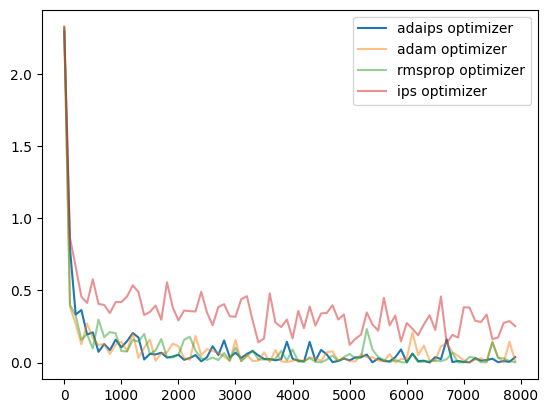

In [49]:

models = [
    (adaIpsModel, 'adaips optimizer'),
    (adamModel, 'adam optimizer'),
    (rmsModel, 'rmsprop optimizer'),
    (ipsModel, 'ips optimizer')

]
exclude = []
focus = [adaIpsModel]
interval = 1
for model, optimizer in models:
    print(model.t_losses)
    plt.plot(
        [i * 100 for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        [loss for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        label=optimizer,
        alpha=0.5 if model not in focus else 1
    )

plt.legend()
plt.show()

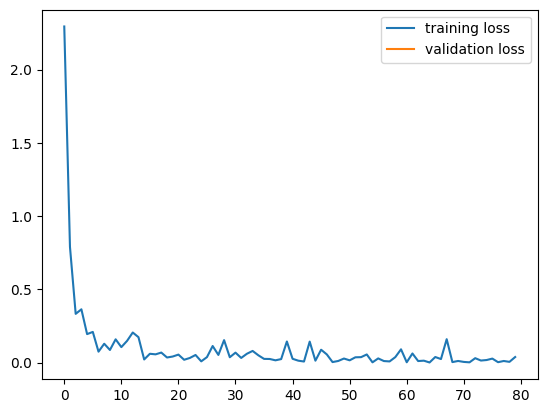

In [50]:

plt.plot([t for t in adaIpsModel.t_losses], label='training loss')
plt.plot([v for v in adaIpsModel.v_losses], label='validation loss')
plt.legend()
plt.show()
